In [36]:
%matplotlib inline
#%matplotlib qt # Choose %matplotlib qt to plot to an interactive window (note it may show up behind your browser)
# Make some of the relevant imports
import cv2 # OpenCV for perspective transform
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import scipy.misc # For saving images as needed
import glob  # For reading in a list of images from a folder
import imageio
imageio.plugins.ffmpeg.download()
import pickle
import numpy as np
import cv2
from PIL import Image


# Identify pixels above the threshold
# Threshold of RGB > 160 does a nice job of identifying ground pixels only
def color_thresh(img, rgb_thresh=(160, 160, 160), rgb_upper_bound=None, invert=False):
    # Create an array of zeros same xy size as img, but single channel
    # dtype is bool for binary image
    color_select = np.zeros_like(img[:, :, 0], dtype=np.bool)
    # Require that each pixel be above all three threshold values in RGB
    # above_thresh will now contain a boolean array with "True"
    # where threshold was met
    above_thresh = (img[:, :, 0] > rgb_thresh[0]) \
                   & (img[:, :, 1] > rgb_thresh[1]) \
                   & (img[:, :, 2] > rgb_thresh[2])

    if rgb_upper_bound:
        below_thresh = (img[:, :, 0] < rgb_upper_bound[0]) \
                       & (img[:, :, 1] < rgb_upper_bound[1]) \
                       & (img[:, :, 2] < rgb_upper_bound[2])
        above_thresh = above_thresh & below_thresh
    # Index the array of zeros with the boolean array and set to 1
    color_select[above_thresh] = 1
    if invert:
        color_select = ~color_select
    # Return the binary image
    return color_select


# Define a function to convert from image coords to rover coords
def rover_coords(binary_img):
    # Identify nonzero pixels
    ypos, xpos = binary_img.nonzero()
    # Calculate pixel positions with reference to the rover position being at the 
    # center bottom of the image.  
    x_pixel = -(ypos - binary_img.shape[0]).astype(np.float)
    y_pixel = -(xpos - binary_img.shape[1] / 2).astype(np.float)
    return x_pixel, y_pixel


# Define a function to convert to radial coords in rover space
def to_polar_coords(x_pixel, y_pixel):
    # Convert (x_pixel, y_pixel) to (distance, angle) 
    # in polar coordinates in rover space
    # Calculate distance to each pixel
    dist = np.sqrt(x_pixel ** 2 + y_pixel ** 2)
    # Calculate angle away from vertical for each pixel
    angles = np.arctan2(y_pixel, x_pixel)
    return dist, angles


# Define a function to map rover space pixels to world space
def rotate_pix(xpix, ypix, yaw):
    # Convert yaw to radians
    yaw_rad = yaw * np.pi / 180
    xpix_rotated = (xpix * np.cos(yaw_rad)) - (ypix * np.sin(yaw_rad))

    ypix_rotated = (xpix * np.sin(yaw_rad)) + (ypix * np.cos(yaw_rad))
    # Return the result  
    return xpix_rotated, ypix_rotated


def translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale):
    # Apply a scaling and a translation
    xpix_translated = (xpix_rot / scale) + xpos
    ypix_translated = (ypix_rot / scale) + ypos
    # Return the result  
    return xpix_translated, ypix_translated


# Define a function to apply rotation and translation (and clipping)
# Once you define the two functions above this function should work
def pix_to_world(xpix, ypix, xpos, ypos, yaw, world_size, scale):
    # Apply rotation
    xpix_rot, ypix_rot = rotate_pix(xpix, ypix, yaw)
    # Apply translation
    xpix_tran, ypix_tran = translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale)
    # Perform rotation, translation and clipping all at once
    x_pix_world = np.clip(np.int_(xpix_tran), 0, world_size - 1)
    y_pix_world = np.clip(np.int_(ypix_tran), 0, world_size - 1)
    # Return the result
    return x_pix_world, y_pix_world


# Define a function to perform a perspective transform
def perspect_transform(img, src, dst):
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))  # keep same size as input image

    return warped

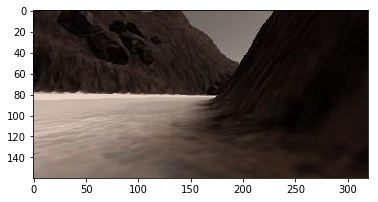

In [2]:
path = '../test_dataset/IMG/*'
#path = 'C:/robotics_rec/IMG/*'
img_list = glob.glob(path)
# Grab a random image and display it
idx = np.random.randint(0, len(img_list)-1)
image = mpimg.imread(img_list[idx])
plt.imshow(image)

In [5]:
class RoverState():
    def __init__(self):
        self.start_time = None # To record the start time of navigation
        self.total_time = None # To record total duration of naviagation
        self.img = None # Current camera image
        self.pos = None # Current position (x, y)
        self.yaw = None # Current yaw angle
        self.pitch = None # Current pitch angle
        self.roll = None # Current roll angle
        self.vel = None # Current velocity
        self.history = []
        self.last_update_time = time.time()
        self.second_counter = time.time()
        self.turn_yaw = 0
        self.picking = False
        self.steer = 0 # Current steering angle
        self.throttle = 0 # Current throttle value
        self.brake = 0 # Current brake value
        self.nav_angles = None # Angles of navigable terrain pixels
        self.nav_dists = None # Distances of navigable terrain pixels
        self.rock_dists = None # Distances of rock terrain pixels
        self.rock_angles = None # Angles of rock terrain pixels
        self.obstacles_dists = None # Angles of rock terrain pixels
        self.obstacles_angles = None # Angles of rock terrain pixels
        self.ground_truth = ground_truth_3d # Ground truth worldmap
        self.mode = 'forward' # Current mode (can be forward or stop)
        self.throttle_set = 0.5 #0.2 #0.2 # Throttle setting when accelerating
        self.brake_set = 10 # Brake setting when braking
        # The stop_forward and go_forward fields below represent total count
        # of navigable terrain pixels.  This is a very crude form of knowing
        # when you can keep going and when you should stop.  Feel free to
        # get creative in adding new fields or modifying these!
        self.stop_forward = 50 # Threshold to initiate stopping
        self.go_forward = 500 # Threshold to go forward again
        self.closest_obstacle_dist_thresh = 50
        self.max_vel = 3 #2 # Maximum velocity (meters/second)
        # Image output from perception step
        # Update this image to display your intermediate analysis steps
        # on screen in autonomous mode
        self.vision_image = np.zeros((160, 320, 3), dtype=np.float) 
        # Worldmap
        # Update this image with the positions of navigable terrain
        # obstacles and rock samples
        self.worldmap = np.zeros((200, 200, 3), dtype=np.float) 
        self.samples_pos = None # To store the actual sample positions
        self.samples_to_find = 0 # To store the initial count of samples
        self.samples_located = 0 # To store number of samples located on map
        self.samples_collected = 0 # To count the number of samples collected
        self.sample_locations_to_find = None
        self.near_sample = 0 # Will be set to telemetry value data["near_sample"]
        self.picking_up = 0 # Will be set to telemetry value data["picking_up"]
        self.send_pickup = False # Set to True to trigger rock pickup

In [32]:
with open('data.pickle', 'rb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    Rover = pickle.load(f)

In [7]:
Rover.brake

0

In [16]:
for k,v in Rover.__dict__.items():
    if isinstance(v, np.ndarray) or isinstance(v, list):
        continue
        
    print(k,"\t\t",v)

total_time 		 17.14942169189453
yaw 		 31.022
second_counter 		 1504082623.0714667
near_sample 		 0
sample_locations_to_find 		 None
roll 		 359.7336
turn_yaw 		 0
picking_up 		 0
brake 		 0
send_pickup 		 False
brake_set 		 10
go_forward 		 500
samples_collected 		 0
samples_to_find 		 6
vel 		 0.9472
max_vel 		 3
last_update_time 		 1504082605.6667356
pitch 		 0.8898
closest_obstacle_dist_thresh 		 50
mode 		 forward
throttle_set 		 0.5
throttle 		 0.5
picking 		 False
samples_located 		 0
steer 		 -14.3881
stop_forward 		 50
start_time 		 1504082605.9095125
samples_pos 		 (array([122, 127,  62, 104, 109, 144]), array([ 51, 121,  88,  80, 101,  94]))


In [40]:
Rover.rock_angles.size
import numpy as np
np.set_printoptions(threshold=np.inf)

In [44]:
angles_in_deg = np.rad2deg(Rover.obstacles_angles)
relevant_angles = (angles_in_deg >= -15) & (angles_in_deg <= 15)
relevant_dist = Rover.obstacles_dists[relevant_angles]
relevant_dist = relevant_dist[relevant_dist > 7]

if relevant_dist.size > 0:
    closest_obstacle_dist = np.min(relevant_dist)
    closest_obstacle_dist < Rover.closest_obstacle_dist_thresh

In [45]:
relevant_dist

array([ 165.42067585,  165.1696098 ,  164.92422502,  164.68454694,
        164.45060049,  164.22241016,  164.        ,  163.78339354,
        163.57261384,  163.36768346,  163.16862443,  162.97545828,
        162.78820596,  162.60688792,  162.43152403,  162.2621336 ,
        162.09873534,  161.94134741,  161.78998733,  161.64467204,
        161.50541787,  161.37224049,  161.24515497,  161.12417572,
        161.0093165 ,  160.90059043,  160.79800994,  160.7015868 ,
        160.6113321 ,  160.52725625,  160.44936896,  160.37767924,
        160.31219542,  160.25292509,  160.19987516,  160.1530518 ,
        160.11246048,  160.07810594,  160.04999219,  160.02812253,
        160.01249951,  160.00312497,  160.        ,  160.00312497,
        164.45364088,  164.20109622,  163.95426191,  163.7131638 ,
        163.47782724,  163.24827717,  163.02453803,  162.80663377,
        162.59458786,  162.38842323,  162.18816233,  161.99382704,
        161.80543872,  161.62301816,  161.44658559,  161.27616

In [23]:
closest_obstacle_dist

1.0

In [24]:
Rover.obstacles_dists

array([ 226.27416998,  225.56817151,  224.86440359, ...,  157.00318468,
        158.00316453,  159.00314462])

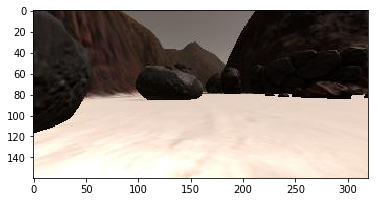

In [25]:
plt.imshow(Rover.img)

In [46]:
image = Rover.img
xpos, ypos = Rover.pos
yaw = Rover.yaw
world_size = 200
scale = 10

# 1) Define source and destination points for perspective transform
dst_size = 5
# Set a bottom offset to account for the fact that the bottom of the image
# is not the position of the rover but a bit in front of it
# this is just a rough guess, feel free to change it!
bottom_offset = 6
source = np.float32([[14, 140], [301, 140], [200, 96], [118, 96]])
destination = np.float32([[image.shape[1] / 2 - dst_size, image.shape[0] - bottom_offset],
                          [image.shape[1] / 2 + dst_size, image.shape[0] - bottom_offset],
                          [image.shape[1] / 2 + dst_size, image.shape[0] - 2 * dst_size - bottom_offset],
                          [image.shape[1] / 2 - dst_size, image.shape[0] - 2 * dst_size - bottom_offset],
                          ])
# 2) Apply perspective transform
warped = perspect_transform(image, source, destination)

# 3) Apply color threshold to identify navigable terrain/obstacles/rock samples
rock_settings = (
    (130, 105, 0),
    (210, 185, 90),
)
rock = color_thresh(warped, rgb_thresh=rock_settings[0], rgb_upper_bound=rock_settings[1])
navigable = color_thresh(warped)
obstacles = color_thresh(warped, invert=True)
terrain_types = (obstacles, rock, navigable)

# 4) Update Rover.vision_image (this will be displayed on left side of screen)
# Example: Rover.vision_image[:,:,0] = obstacle color-thresholded binary image
#          Rover.vision_image[:,:,1] = rock_sample color-thresholded binary image
#          Rover.vision_image[:,:,2] = navigable terrain color-thresholded binary image
for i, threshed in enumerate(terrain_types):
    # set color channel to the max
    Rover.vision_image[:, :, i] = threshed.astype(np.uint8) * 255

    # 5) Convert map image pixel values to rover-centric coords
    xpix, ypix = rover_coords(threshed)

    # 6) Convert rover-centric pixel values to world coordinates
    x_pix_world, y_pix_world = pix_to_world(xpix, ypix, xpos, ypos, yaw, world_size, scale)

    # 7) Update Rover worldmap (to be displayed on right side of screen)
    # Example: Rover.worldmap[obstacle_y_world, obstacle_x_world, 0] += 1
    #          Rover.worldmap[rock_y_world, rock_x_world, 1] += 1
    #          Rover.worldmap[navigable_y_world, navigable_x_world, 2] += 1
    Rover.worldmap[y_pix_world, x_pix_world, i] += 1

    # 8) Convert rover-centric pixel positions to polar coordinates
    # Update Rover pixel distances and angles
    # Rover.nav_dists = rover_centric_pixel_distances
    # Rover.nav_angles = rover_centric_angles
x_pixel, y_pixel = rover_coords(navigable)
rover_centric_pixel_distances, rover_centric_angles = to_polar_coords(x_pixel, y_pixel)
Rover.nav_dists = rover_centric_pixel_distances
Rover.nav_angles = rover_centric_angles

x_pixel, y_pixel = rover_coords(rock)
rover_centric_pixel_distances, rover_centric_angles = to_polar_coords(x_pixel, y_pixel)
Rover.rock_dists = rover_centric_pixel_distances
Rover.rock_angles = rover_centric_angles

x_pixel, y_pixel = rover_coords(obstacles)
rover_centric_pixel_distances, rover_centric_angles = to_polar_coords(x_pixel, y_pixel)
Rover.obstacles_dists = rover_centric_pixel_distances
Rover.obstacles_angles = rover_centric_angles

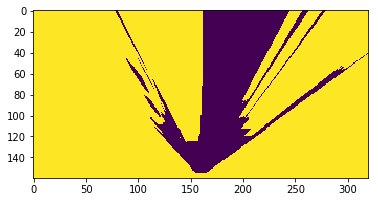

In [29]:
plt.imshow(obstacles)

In [68]:
obstacles.shape
import scipy
dist_matrix=scipy.spatial.distance.pdist(obs2)

In [55]:
Rover.obstacles_dists.shape

(41199,)

In [56]:
Rover.obstacles_angles.shape

(41199,)

In [102]:
160*320
dist = np.sqrt((55 - 160)**2 + (55-160)**2)
dist

m = np.zeros_like(obs2, dtype=np.float)
for i in range(m.shape[0]):
    for j in range(m.shape[1]):
        m[i][j] = np.sqrt((i - 160.0)**2 + (j-160.0)**2)
        
n = np.zeros_like(obs2, dtype=np.float)
for i in range(n.shape[0]):
    for j in range(n.shape[1]):
        n[i][j] = np.rad2deg(np.arctan2(j - 160.0, i - 160.0))

In [103]:
n

array([[-135.        , -135.17961001, -135.36034606, -135.54221516,
        -135.7252243 , -135.90938045, -136.09469059, -136.28116169,
        -136.46880071, -136.6576146 , -136.84761027, -137.03879464,
        -137.23117461, -137.42475704, -137.6195488 , -137.81555668,
        -138.0127875 , -138.21124802, -138.41094496, -138.61188501,
        -138.81407483, -139.01752104, -139.22223021, -139.42820884,
        -139.63546343, -139.84400038, -140.05382605, -140.26494675,
        -140.47736873, -140.69109815, -140.90614111, -141.12250366,
        -141.34019175, -141.55921124, -141.77956795, -142.00126756,
        -142.22431569, -142.44871787, -142.67447952, -142.90160594,
        -143.13010235, -143.35997386, -143.59122543, -143.82386194,
        -144.05788813, -144.2933086 , -144.53012783, -144.76835017,
        -145.0079798 , -145.24902078, -145.49147701, -145.73535223,
        -145.98065001, -146.22737377, -146.47552675, -146.72511202,
        -146.97613244, -147.22859073, -147.48248

In [65]:
rover_pos = (obstacles.shape[0]-1, obstacles.shape[1]/2)
obs2 = obstacles.copy()

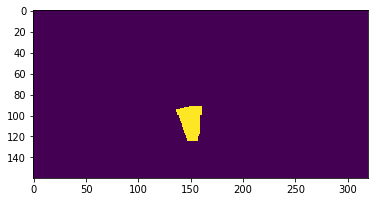

In [119]:
plt.imshow(obs2 & (m > 7) & (m < 70) & ((n < -160) | (n > 160)))

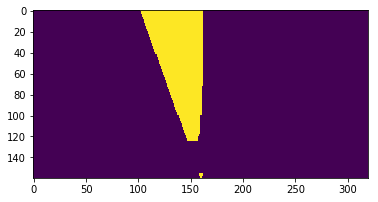

In [116]:
plt.imshow(obs2 & ((n < -160) | (n > 160)))

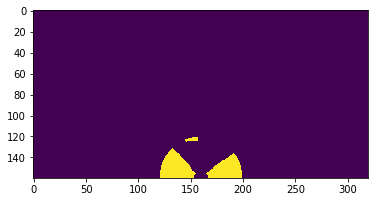

In [118]:
plt.imshow(obs2 & (m > 7) & (m < 40))

In [37]:
pil_img = Image.fromarray(Rover.vision_image.astype(np.uint8))

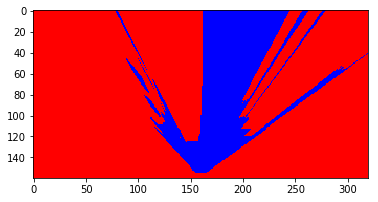

In [38]:
plt.imshow(pil_img)

In [49]:
np.deg2rad(359.0)

6.2657320146596431

In [50]:
def close_to_zero_deg(angle, max_error_deg):
    return angle < max_error_deg or angle > (360.0 - max_error_deg)

In [51]:
close_to_zero_deg(355, 10)

True

In [52]:
close_to_zero_deg(4, 10)

True